In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import make_grid

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import math
import cv2
%matplotlib inline

In [3]:
num_of_epochs = 3

In [4]:
print(torch.cuda.is_available())
print(torch.backends.cudnn.enabled)

if torch.cuda.is_available():
    device = torch.device('cuda')


False
True


## Read data

In [5]:
path_list = []
letter = []
dirName = './dataset_mnist'
for path, subdirs, files in os.walk(dirName):
    for name in files:
        letter.append(path[-3])
        if path[-3] == 'o':
            print(path)
        path_list.append(os.path.join(path, name))
        
        #dataset[os.path.join(path, name)] = path[-3]
        #print(os.path.join(path, name))
        #print(path[-3])
#print(dataset)
#print(path_list)

## Showcase data

## Splitting dataset

In [6]:
test_path = []
test_letters = []
#test_images = []
train_path = []
train_letters = []
#train_images = []
for i in range(len(path_list)):
    if (i % 3 == 0):
        test_path.append(path_list[i])
        test_letters.append(letter[i])
        #test_images = io.imread(path_list[i])
    else:
        train_path.append(path_list[i])
        train_letters.append(letter[i])
        #train_images = io.imread(path_list[i])

# Building Dataset

In [7]:
lettersIndex = ['А', 'Б', 'В', 'Г', 'Ґ', 'Д', 'Е', 'Є', 'Ж', 'З', 'И', 'І', 'Ї', 'Й', 'К', 'Л', 'М', 'Н', 'О', 'П', 'Р', 'С', 'Т', 'У', 'Ф', 'Х', 'Ч', 'Ц', 'Ч', 'Ш', 'Щ', 'Ь', 'Ю', 'Я']

In [8]:
from skimage import io, transform

class MNISTCyrDataset(torch.utils.data.Dataset):
    """MNIST cyrillics dataset"""

    def __init__(self, file_paths, file_letters, transform=None):
        """
        Args:

        """
        self.file_paths = file_paths
        self.file_letters = file_letters
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.file_paths[idx]
        image = io.imread(img_name)
        
        sample = [image, lettersIndex.index(self.file_letters[idx])]
        if self.transform:
            sample[0] = self.transform(sample[0])

        return sample

In [9]:

test_dataset = MNISTCyrDataset(file_paths=test_path, file_letters=test_letters, transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.5,), (0.5,)),
                               torchvision.transforms.Grayscale(1),
                               torchvision.transforms.Resize((32, 32))
                             ]))

test_loader = torch.utils.data.DataLoader(test_dataset, 32, shuffle=True)

In [10]:
train_dataset = MNISTCyrDataset(file_paths=train_path, file_letters=train_letters, transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.5,), (0.5,)),
                               torchvision.transforms.Grayscale(1),
                               torchvision.transforms.Resize((32, 32))
                             ]))

train_loader = torch.utils.data.DataLoader(test_dataset, 32, shuffle=True)

In [11]:
image , label = train_dataset[32]
image.size()

torch.Size([1, 32, 32])

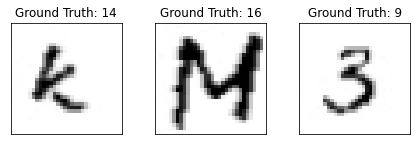

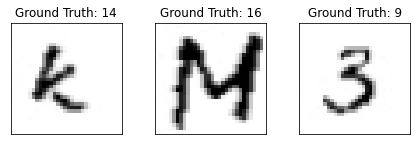

In [21]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
fig = plt.figure()
for i in range(3):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
fig

# Building Network

In [12]:
class ConvolutionNNetwork(nn.Module):
    def __init__(self):
        super(ConvolutionNNetwork, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(1024, 1000)
        self.fc2 = nn.Linear(1000, 34)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [13]:
# Train the model
num_epochs = 32
learning_rate = 0.001
total_step = len(train_loader)
loss_list = []
acc_list = []
model = ConvolutionNNetwork()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate);
criterion = nn.CrossEntropyLoss();

In [14]:
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track the accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))

Epoch [1/32], Step [100/2698], Loss: 3.1824, Accuracy: 21.88%
Epoch [1/32], Step [200/2698], Loss: 1.9857, Accuracy: 40.62%
Epoch [1/32], Step [300/2698], Loss: 1.8519, Accuracy: 62.50%
Epoch [1/32], Step [400/2698], Loss: 1.7755, Accuracy: 53.12%
Epoch [1/32], Step [500/2698], Loss: 1.5764, Accuracy: 62.50%
Epoch [1/32], Step [600/2698], Loss: 1.1815, Accuracy: 71.88%
Epoch [1/32], Step [700/2698], Loss: 1.3320, Accuracy: 71.88%
Epoch [1/32], Step [800/2698], Loss: 1.4333, Accuracy: 62.50%
Epoch [1/32], Step [900/2698], Loss: 0.8954, Accuracy: 78.12%
Epoch [1/32], Step [1000/2698], Loss: 0.9100, Accuracy: 87.50%
Epoch [1/32], Step [1100/2698], Loss: 1.3246, Accuracy: 71.88%
Epoch [1/32], Step [1200/2698], Loss: 1.8798, Accuracy: 65.62%
Epoch [1/32], Step [1300/2698], Loss: 1.2701, Accuracy: 68.75%
Epoch [1/32], Step [1400/2698], Loss: 1.2323, Accuracy: 75.00%
Epoch [1/32], Step [1500/2698], Loss: 1.2516, Accuracy: 62.50%
Epoch [1/32], Step [1600/2698], Loss: 1.7409, Accuracy: 59.38%
E

Epoch [6/32], Step [200/2698], Loss: 1.2551, Accuracy: 78.12%
Epoch [6/32], Step [300/2698], Loss: 0.6553, Accuracy: 87.50%
Epoch [6/32], Step [400/2698], Loss: 0.8999, Accuracy: 81.25%
Epoch [6/32], Step [500/2698], Loss: 0.8079, Accuracy: 87.50%
Epoch [6/32], Step [600/2698], Loss: 1.0445, Accuracy: 81.25%
Epoch [6/32], Step [700/2698], Loss: 1.0809, Accuracy: 78.12%
Epoch [6/32], Step [800/2698], Loss: 0.9063, Accuracy: 84.38%
Epoch [6/32], Step [900/2698], Loss: 0.9109, Accuracy: 84.38%
Epoch [6/32], Step [1000/2698], Loss: 0.8165, Accuracy: 84.38%
Epoch [6/32], Step [1100/2698], Loss: 0.3215, Accuracy: 93.75%
Epoch [6/32], Step [1200/2698], Loss: 0.9202, Accuracy: 81.25%
Epoch [6/32], Step [1300/2698], Loss: 1.6560, Accuracy: 62.50%
Epoch [6/32], Step [1400/2698], Loss: 0.6908, Accuracy: 90.62%
Epoch [6/32], Step [1500/2698], Loss: 1.1723, Accuracy: 78.12%
Epoch [6/32], Step [1600/2698], Loss: 1.3593, Accuracy: 71.88%
Epoch [6/32], Step [1700/2698], Loss: 1.1548, Accuracy: 84.38%


Epoch [11/32], Step [300/2698], Loss: 0.7266, Accuracy: 81.25%
Epoch [11/32], Step [400/2698], Loss: 0.6872, Accuracy: 87.50%
Epoch [11/32], Step [500/2698], Loss: 0.8258, Accuracy: 87.50%
Epoch [11/32], Step [600/2698], Loss: 1.0286, Accuracy: 78.12%
Epoch [11/32], Step [700/2698], Loss: 0.7952, Accuracy: 81.25%
Epoch [11/32], Step [800/2698], Loss: 0.5997, Accuracy: 90.62%
Epoch [11/32], Step [900/2698], Loss: 0.6826, Accuracy: 90.62%
Epoch [11/32], Step [1000/2698], Loss: 0.3246, Accuracy: 93.75%
Epoch [11/32], Step [1100/2698], Loss: 0.6877, Accuracy: 84.38%
Epoch [11/32], Step [1200/2698], Loss: 0.8990, Accuracy: 84.38%
Epoch [11/32], Step [1300/2698], Loss: 0.5885, Accuracy: 84.38%
Epoch [11/32], Step [1400/2698], Loss: 1.1502, Accuracy: 75.00%
Epoch [11/32], Step [1500/2698], Loss: 1.5273, Accuracy: 78.12%
Epoch [11/32], Step [1600/2698], Loss: 0.5149, Accuracy: 87.50%
Epoch [11/32], Step [1700/2698], Loss: 0.4076, Accuracy: 96.88%
Epoch [11/32], Step [1800/2698], Loss: 1.0148, 

Epoch [16/32], Step [200/2698], Loss: 0.2239, Accuracy: 93.75%
Epoch [16/32], Step [300/2698], Loss: 1.1274, Accuracy: 84.38%
Epoch [16/32], Step [400/2698], Loss: 1.2090, Accuracy: 84.38%
Epoch [16/32], Step [500/2698], Loss: 0.7454, Accuracy: 78.12%
Epoch [16/32], Step [600/2698], Loss: 1.2029, Accuracy: 78.12%
Epoch [16/32], Step [700/2698], Loss: 1.0026, Accuracy: 75.00%
Epoch [16/32], Step [800/2698], Loss: 1.6807, Accuracy: 68.75%
Epoch [16/32], Step [900/2698], Loss: 0.6096, Accuracy: 87.50%
Epoch [16/32], Step [1000/2698], Loss: 0.6375, Accuracy: 90.62%
Epoch [16/32], Step [1100/2698], Loss: 0.8448, Accuracy: 78.12%
Epoch [16/32], Step [1200/2698], Loss: 0.7303, Accuracy: 87.50%
Epoch [16/32], Step [1300/2698], Loss: 0.6073, Accuracy: 93.75%
Epoch [16/32], Step [1400/2698], Loss: 1.2138, Accuracy: 71.88%
Epoch [16/32], Step [1500/2698], Loss: 0.1755, Accuracy: 100.00%
Epoch [16/32], Step [1600/2698], Loss: 1.3015, Accuracy: 84.38%
Epoch [16/32], Step [1700/2698], Loss: 0.6536, 

Epoch [21/32], Step [100/2698], Loss: 0.7693, Accuracy: 87.50%
Epoch [21/32], Step [200/2698], Loss: 0.6954, Accuracy: 84.38%
Epoch [21/32], Step [300/2698], Loss: 1.2077, Accuracy: 78.12%
Epoch [21/32], Step [400/2698], Loss: 1.4194, Accuracy: 78.12%
Epoch [21/32], Step [500/2698], Loss: 0.8264, Accuracy: 75.00%
Epoch [21/32], Step [600/2698], Loss: 0.6468, Accuracy: 84.38%
Epoch [21/32], Step [700/2698], Loss: 0.5260, Accuracy: 90.62%
Epoch [21/32], Step [800/2698], Loss: 0.6941, Accuracy: 81.25%
Epoch [21/32], Step [900/2698], Loss: 0.4811, Accuracy: 84.38%
Epoch [21/32], Step [1000/2698], Loss: 0.5732, Accuracy: 90.62%
Epoch [21/32], Step [1100/2698], Loss: 0.5762, Accuracy: 90.62%
Epoch [21/32], Step [1200/2698], Loss: 0.8238, Accuracy: 87.50%
Epoch [21/32], Step [1300/2698], Loss: 1.0328, Accuracy: 78.12%
Epoch [21/32], Step [1400/2698], Loss: 0.2667, Accuracy: 87.50%
Epoch [21/32], Step [1500/2698], Loss: 1.0905, Accuracy: 78.12%
Epoch [21/32], Step [1600/2698], Loss: 1.0158, Ac

Epoch [25/32], Step [2600/2698], Loss: 0.8825, Accuracy: 81.25%
Epoch [26/32], Step [100/2698], Loss: 0.4445, Accuracy: 90.62%
Epoch [26/32], Step [200/2698], Loss: 0.4221, Accuracy: 90.62%
Epoch [26/32], Step [300/2698], Loss: 0.8019, Accuracy: 78.12%
Epoch [26/32], Step [400/2698], Loss: 0.4765, Accuracy: 90.62%
Epoch [26/32], Step [500/2698], Loss: 0.4298, Accuracy: 87.50%
Epoch [26/32], Step [600/2698], Loss: 0.9842, Accuracy: 78.12%
Epoch [26/32], Step [700/2698], Loss: 0.9538, Accuracy: 78.12%
Epoch [26/32], Step [800/2698], Loss: 0.5130, Accuracy: 93.75%
Epoch [26/32], Step [900/2698], Loss: 0.6776, Accuracy: 84.38%
Epoch [26/32], Step [1000/2698], Loss: 1.2586, Accuracy: 78.12%
Epoch [26/32], Step [1100/2698], Loss: 0.6942, Accuracy: 84.38%
Epoch [26/32], Step [1200/2698], Loss: 0.8338, Accuracy: 78.12%
Epoch [26/32], Step [1300/2698], Loss: 0.5654, Accuracy: 90.62%
Epoch [26/32], Step [1400/2698], Loss: 0.4313, Accuracy: 93.75%
Epoch [26/32], Step [1500/2698], Loss: 0.6165, Ac

Epoch [30/32], Step [2500/2698], Loss: 0.8579, Accuracy: 75.00%
Epoch [30/32], Step [2600/2698], Loss: 0.3777, Accuracy: 87.50%
Epoch [31/32], Step [100/2698], Loss: 0.3972, Accuracy: 96.88%
Epoch [31/32], Step [200/2698], Loss: 1.0941, Accuracy: 75.00%
Epoch [31/32], Step [300/2698], Loss: 1.0035, Accuracy: 75.00%
Epoch [31/32], Step [400/2698], Loss: 0.5392, Accuracy: 90.62%
Epoch [31/32], Step [500/2698], Loss: 1.0649, Accuracy: 71.88%
Epoch [31/32], Step [600/2698], Loss: 0.9883, Accuracy: 81.25%
Epoch [31/32], Step [700/2698], Loss: 1.2966, Accuracy: 81.25%
Epoch [31/32], Step [800/2698], Loss: 0.3983, Accuracy: 90.62%
Epoch [31/32], Step [900/2698], Loss: 0.5633, Accuracy: 87.50%
Epoch [31/32], Step [1000/2698], Loss: 0.7907, Accuracy: 75.00%
Epoch [31/32], Step [1100/2698], Loss: 0.7227, Accuracy: 84.38%
Epoch [31/32], Step [1200/2698], Loss: 0.9780, Accuracy: 81.25%
Epoch [31/32], Step [1300/2698], Loss: 1.1723, Accuracy: 75.00%
Epoch [31/32], Step [1400/2698], Loss: 0.3424, Ac

In [15]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for (images, labels) in test_loader:

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy: {} %'.format((correct / total) * 100))


Accuracy: 86.18156537859916 %
